# <center>$m$-Generalized uniform scenario - Methods</center>

## <center>A bunch of maths</center>


$$ \underbrace{\sum_{j\neq i} \underbrace{\frac{k_j t}{\delta_j(t)} \cdot  \delta_j'(t)}_{x_j}}_{(Ax)_i}= \underbrace{{\frac{1}{\delta_i(t)-1}-\sum_{j\neq i}k_j}}_{y_i} \text{ for } i=1,\dots,n$$

$$ l_i = 1+\frac{1}{\sum_{j\neq i}k_j} $$

$$ A^{-1} = \begin{pmatrix}
0 &1  &\dots  & 1\\ 
1 &  0&  \dots& 1 \\ 
\vdots &\vdots &\ddots  & \vdots \\ 
1 & 1 &\dots  &0 
\end{pmatrix}^{-1}
=
\frac{1}{n-1} \begin{pmatrix}
-(n-2) &1  &\dots  &1 \\ 
1 &-(n-2) &\dots  & 1 \\ 
\vdots &\vdots  & \ddots & \vdots\\ 
1 &1  &\dots  & -(n-2)
\end{pmatrix}$$

## <center>Python methods</center>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Import, display and stuff

In [4]:
def bid_i_f(v,i,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values_'][i],v)/(method_out['N']+1)

In [65]:
def display_mGU(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coalitions {}".format(out['k_']))
    
    plt.subplot(131)
    v_ = np.linspace(0,1,1001)
    
    for i in range(out['m']) :
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta_'][i],'b',label=r'$\delta_{}$'.format(i))
        plt.axhline(out['l_'][i],color='b',linestyle='--')
        
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    #plt.ylim((min(out['l2_star'],out['l1_star'])-0.1,max(out['l2_star'],out['l1_star'])+0.1))
    plt.title(r"Approximated functions : $\delta_i(t) = \lambda_i(t)/t$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    
    for i in range(out['m']) :
        plt.plot(b_,out['values_'][i],'b',label=r'$\lambda_{}$'.format(i))
        plt.plot(b_,out['l_'][i]*b_,'b--')
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)    
    for i in range(out['m']) :
        plt.plot(v_,[bid_i_f(v,i,out) for v in v_],'b',label=r"$\phi_{}$".format(i))
        plt.plot(v_,1/out['l_'][i]*v_,'b--')
        
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

### Shooting and Iterate methods

In [138]:
def shoot_mGU(tstar,k_,N=10_000,correct=True) :
    
    if(np.any(k_==0)) :
        print("Every coalition size should be != 0")
        return
    
    k_ = np.array(k_)
    m = len(k_)
    
    delta_ = np.zeros((m,N+2))
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    output = {}
    output['m'] = m
    output['tstar'] = tstar
    output['N'] = N
    output['breakpoint'] = 0
    output['l_'] = l_
    output['k_'] = k_
    
    A_inv = 1/(m-1)*((np.ones((m,m))-np.eye(m))-(m-2)*np.eye(m))
    
    eps_f = lambda i : np.linalg.norm(delta_[:,i]-l_,2)
    
    delta_[:,N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
        tjm1 = tstar*(j-1)/(N+1)
        
        #A = np.ones((m,m))-np.eye(m)
        #y = np.array([ 1/(delta_[i,j]-1) - (np.sum(k_)-k_[i]) for i in range(m)])
        #x = np.linalg.solve(A,y)
        #delta_p_[:,j] = delta_[:,j]/(tj*k_)*x
        
        y = 1/(delta_[:,j]-1) - (np.sum(k_)-k_)
        x = A_inv@y
        
        #deltap_j_ = delta_[:,j]/(tj*k_)*x
        #delta_[:,j-1] = delta_[:,j]+(tjm1-tj)*deltap_j_
        
        delta_[:,j-1] = delta_[:,j]*(1-x/(j*k_))
        
        if(output['breakpoint'] == 0 and eps_f(j-1) > eps_f(j) ) :
            output['breakpoint'] = j
            if(correct) :
                break

    output['eps_star'] = eps_f(output['breakpoint'])
    if(correct) :
        ind = output['breakpoint']
        for i in range(m) :
            delta_[i,:ind+1] = np.linspace(l_[i],delta_[i,ind],ind+1)
        
    output['delta_'] = delta_
    output['values_'] = np.zeros_like(delta_)
    output['values_'] = np.linspace(0,tstar,N+2)*delta_
        
    return output

In [132]:
def iterate_mGU(k_,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    if(np.any(k_==0)) :
        print("Every coalition size should be != 0")
        return
    
    k_ = np.array(k_)
    m = len(k_)
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    a = 1/np.max(l_)
    b = 1/np.min(l_)
                 
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
    
    x_2 = a + tau*(b-a)
    f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(f_1['eps_star']<f_2['eps_star']) :
            print("tstar :",f_1['tstar'])
        else :
            print("tstar :",f_2['tstar'])
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
            
    if(f_1['eps_star']<f_2['eps_star']) :
        if(display_graphs) :
            display_mGU(f_1)
        return f_1
    else :
        if(display_graphs) :
            display_mGU(f_2)
        return f_2

### Tests

#### $m$ symetric Beta$(\alpha,1)$-valuing bidders<br>
$\implies$ linear bid functions $v\mapsto \frac{\alpha(m-1)}{\alpha(m-1)+1}v$

Nb of eval : 2
eps_star : 0.0
tstar : 0.9523809523809523


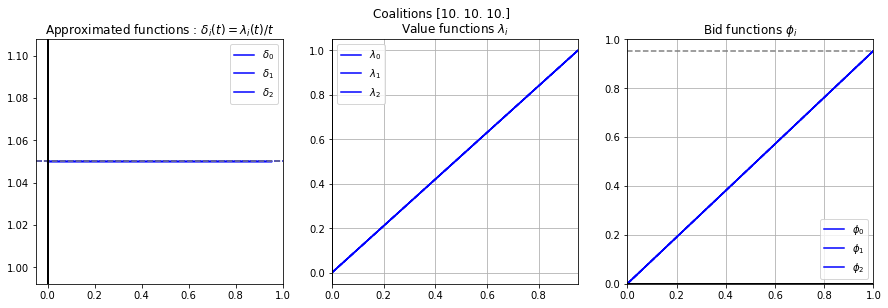

In [134]:
alpha = 10
m = 3
iterate_mGU(alpha*np.ones(m),show_msg=True,display_graphs=True);

#### [Marshall1994] Fig1 page 205 :  $k_1=4, k_2=1$

Nb of eval : 28
eps_star : 5.1989691884089565e-05
tstar : 0.6373710009110503


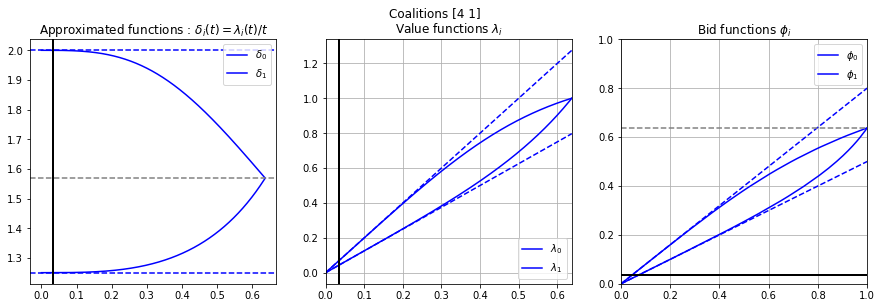

In [135]:
iterate_mGU([4,1],eps=10**-4,show_msg=True,display_graphs=True);

#### [Marshall1994] Fig3 page 213 :  $k_1=99, k_2=1,k_2=1$

Nb of eval : 41
eps_star : 8.849954404942241e-06
tstar : 0.8411144314740581


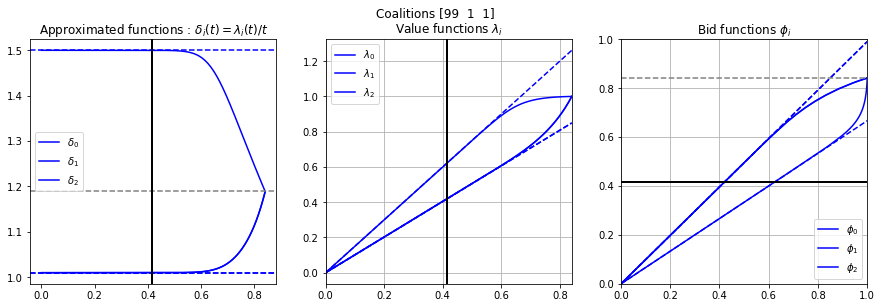

In [136]:
iterate_mGU([99,1,1],eps=10**-5,display_graphs=True,show_msg=True);

#### New asymetric test : $k_1=8,k_2=4,k_3=1$

Nb of eval : 32
eps_star : 5.585664851440183e-06
tstar : 0.7869532318043985


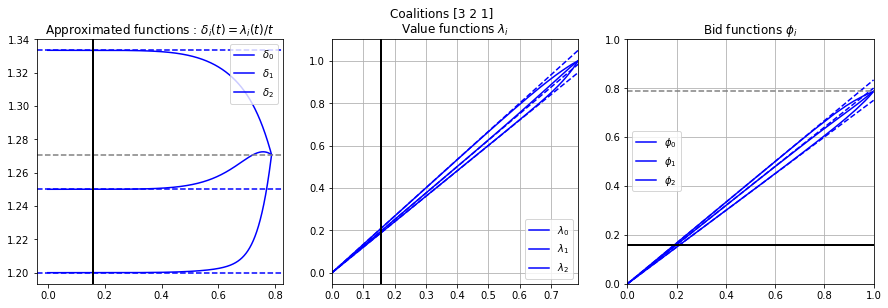

In [137]:
iterate_mGU([3,2,1],eps=10**-5,show_msg=True,display_graphs=True);